In [37]:
import numpy as np
import matplotlib.pyplot as plt

In [38]:
# Cell 2: Utility Functions
def rot_z(theta):
    c, s = np.cos(theta), np.sin(theta)
    return np.array([[ c, -s, 0, 0],
                     [ s,  c, 0, 0],
                     [ 0,  0, 1, 0],
                     [ 0,  0, 0, 1]])

def rot_y(theta):
    c, s = np.cos(theta), np.sin(theta)
    return np.array([[ c,  0, s, 0],
                     [ 0,  1, 0, 0],
                     [-s,  0, c, 0],
                     [ 0,  0, 0, 1]])

def trans(x, y, z):
    M = np.eye(4)
    M[0,3] = x
    M[1,3] = y
    M[2,3] = z
    return M

In [39]:
# Cell 3: Robot Parameters (Dobot Magician Lite approx, mm)
params = {
    'base_height': 107.0,  # mm, vertical height from base to shoulder pivot
    'L2': 150.0,           # mm, upper arm length
    'L3': 150.0,           # mm, forearm length
    'd_ee': 40.0           # mm, tool offset from wrist pivot to tip (along forearm/wrist direction)
}

In [40]:
# Cell 4: Forward Kinematics
def forward_kinematics(q, p=params):
    q1, q2, q3, q4 = q
    base_h = p['base_height']
    L2 = p['L2']
    L3 = p['L3']
    d_ee = p['d_ee']
    
    T = rot_z(q1) @ trans(0,0,base_h) \
        @ rot_y(q2) @ trans(L2, 0, 0) \
        @ rot_y(q3) @ trans(L3, 0, 0) \
        @ rot_y(q4) @ trans(d_ee, 0, 0)
    
    x, y, z = T[0,3], T[1,3], T[2,3]
    phi = q2 + q3 + q4  # effective pitch
    
    return T, (x, y, z, phi)

In [41]:
# Cell 5: Inverse Kinematics
def inverse_kinematics(x, y, z, phi, p=params, prefer_elbow='both'):
    base_h = p['base_height']
    L2 = p['L2']
    L3 = p['L3']
    d_ee = p['d_ee']
    
    solutions = []
    r = np.hypot(x, y)
    q1 = np.arctan2(y, x) if r > 1e-9 else 0.0
    
    dx = d_ee * np.cos(phi)
    dz = d_ee * np.sin(phi)
    r_wrist = r - dx
    z_wrist = z - base_h - dz
    
    D = (r_wrist**2 + z_wrist**2 - L2**2 - L3**2) / (2 * L2 * L3)
    if np.abs(D) > 1.0 + 1e-9:
        return []  # unreachable
    D = np.clip(D, -1.0, 1.0)
    
    q3_options = []
    if prefer_elbow in ('both','down'):
        q3_options.append(np.arctan2(+np.sqrt(1 - D**2), D))
    if prefer_elbow in ('both','up'):
        q3_options.append(np.arctan2(-np.sqrt(1 - D**2), D))
    
    for q3 in q3_options:
        k1 = L2 + L3*np.cos(q3)
        k2 = L3*np.sin(q3)
        q2 = np.arctan2(z_wrist, r_wrist) - np.arctan2(k2, k1)
        q4 = phi - q2 - q3
        sol = np.array([q1, q2, q3, q4])
        sol = (sol + np.pi) % (2*np.pi) - np.pi
        solutions.append(sol)
    
    return solutions

In [42]:
# Cell 6: Test FK and IK
# Define test joint angles
q_test = np.deg2rad([30.0, -30.0, 45.0, -10.0])  

# Forward Kinematics
T, pose = forward_kinematics(q_test)
print("FK Result -> Pose (x, y, z, phi):", pose)
print("\nHomogeneous Transformation Matrix:\n", T)

# Inverse Kinematics
x, y, z, phi = pose
solutions = inverse_kinematics(x, y, z, phi)

print("\nIK Solutions (degrees):")
for s in solutions:
    print(np.rad2deg(s))

# Validate by plugging solutions back into FK
for s in solutions:
    _, recon_pose = forward_kinematics(s)
    print("Reconstructed Pose from IK:", recon_pose)

FK Result -> Pose (x, y, z, phi): (272.4866421871841, 157.32023621734794, 139.69091352471554, 0.08726646259971652)

Homogeneous Transformation Matrix:
 [[ 8.62729916e-01 -5.00000000e-01  7.54790873e-02  2.72486642e+02]
 [ 4.98097349e-01  8.66025404e-01  4.35778714e-02  1.57320236e+02]
 [-8.71557427e-02  0.00000000e+00  9.96194698e-01  1.39690914e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]

IK Solutions (degrees):
[ 30.         -16.84098022  45.81508812 -23.9741079 ]
[ 30.          28.9741079  -45.81508812  21.84098022]
Reconstructed Pose from IK: (272.48664218718415, 157.32023621734788, 74.30908647528445, 0.08726646259971638)
Reconstructed Pose from IK: (272.48664218718415, 157.32023621734788, 74.30908647528443, 0.08726646259971682)


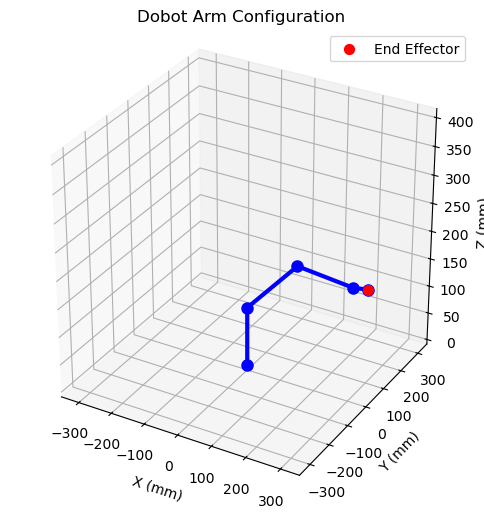

<Axes3D: title={'center': 'Dobot Arm Configuration'}, xlabel='X (mm)', ylabel='Y (mm)', zlabel='Z (mm)'>

In [43]:
# Cell 7: 3D Visualization of Dobot Arm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_dobot(q, p=params, ax=None, show=True):
    q1, q2, q3, q4 = q
    base_h = p['base_height']
    L2 = p['L2']
    L3 = p['L3']
    d_ee = p['d_ee']
    
    # Forward kinematics step by step (to extract joint positions)
    T0 = np.eye(4)
    p0 = T0[:3,3]  # base at origin
    
    T1 = rot_z(q1) @ trans(0,0,base_h)
    p1 = T1[:3,3]  # shoulder position
    
    T2 = T1 @ rot_y(q2) @ trans(L2,0,0)
    p2 = T2[:3,3]  # elbow position
    
    T3 = T2 @ rot_y(q3) @ trans(L3,0,0)
    p3 = T3[:3,3]  # wrist position
    
    T4 = T3 @ rot_y(q4) @ trans(d_ee,0,0)
    p4 = T4[:3,3]  # end-effector
    
    # Collect joint positions
    xs = [p0[0], p1[0], p2[0], p3[0], p4[0]]
    ys = [p0[1], p1[1], p2[1], p3[1], p4[1]]
    zs = [p0[2], p1[2], p2[2], p3[2], p4[2]]
    
    if ax is None:
        fig = plt.figure(figsize=(6,6))
        ax = fig.add_subplot(111, projection='3d')
    
    # Plot arm
    ax.plot(xs, ys, zs, '-o', linewidth=3, markersize=8, color='blue')
    
    # Mark end effector
    ax.scatter(p4[0], p4[1], p4[2], color='red', s=50, label='End Effector')
    
    # Set labels and limits
    ax.set_xlabel("X (mm)")
    ax.set_ylabel("Y (mm)")
    ax.set_zlabel("Z (mm)")
    ax.set_title("Dobot Arm Configuration")
    ax.legend()
    
    ax.set_box_aspect([1,1,1])  # equal aspect ratio
    lim = (-(L2+L3+d_ee), (L2+L3+d_ee))
    ax.set_xlim(lim)
    ax.set_ylim(lim)
    ax.set_zlim(0, L2+L3+base_h)
    
    if show:
        plt.show()
    
    return ax

# Example: visualize test pose
plot_dobot(q_test)

In [44]:
# Function to plot the Dobot arm in 3D
def plot_dobot(q, ax=None, show=True):
    q1, q2, q3, q4 = np.deg2rad(q)  # convert degrees to radians if input is in degrees
    
    base_h = params['base_height']
    L2 = params['L2']
    L3 = params['L3']
    d_ee = params['d_ee']
    
    # Forward kinematics step by step (just positions of joints for plotting)
    p0 = np.array([0, 0, 0])                       # base
    p1 = np.array([0, 0, base_h])                  # shoulder joint
    
    # shoulder to elbow
    x2 = p1[0] + L2 * np.cos(q2) * np.cos(q1)
    y2 = p1[1] + L2 * np.cos(q2) * np.sin(q1)
    z2 = p1[2] + L2 * np.sin(q2)
    p2 = np.array([x2, y2, z2])
    
    # elbow to wrist
    x3 = x2 + L3 * np.cos(q2 + q3) * np.cos(q1)
    y3 = y2 + L3 * np.cos(q2 + q3) * np.sin(q1)
    z3 = z2 + L3 * np.sin(q2 + q3)
    p3 = np.array([x3, y3, z3])
    
    # wrist to tool tip
    x4 = x3 + d_ee * np.cos(q2 + q3 + q4) * np.cos(q1)
    y4 = y3 + d_ee * np.cos(q2 + q3 + q4) * np.sin(q1)
    z4 = z3 + d_ee * np.sin(q2 + q3 + q4)
    p4 = np.array([x4, y4, z4])
    
    # Collect points
    pts = np.vstack([p0, p1, p2, p3, p4])
    
    # Plot
    if ax is None:
        fig = plt.figure(figsize=(6,6))
        ax = fig.add_subplot(111, projection="3d")
    
    ax.plot(pts[:,0], pts[:,1], pts[:,2], "-o", lw=2, c="b")
    ax.set_xlabel("X (mm)")
    ax.set_ylabel("Y (mm)")
    ax.set_zlabel("Z (mm)")
    ax.set_xlim(-300, 300)
    ax.set_ylim(-300, 300)
    ax.set_zlim(0, 400)
    ax.view_init(elev=30, azim=45)
    
    if show:
        plt.show()


In [45]:
# Robot parameters (mm)
params = {
    'base_height': 107.0,  # mm
    'L2': 150.0,           # mm, upper arm length
    'L3': 150.0,           # mm, forearm length
    'd_ee': 40.0           # mm, tool offset
}

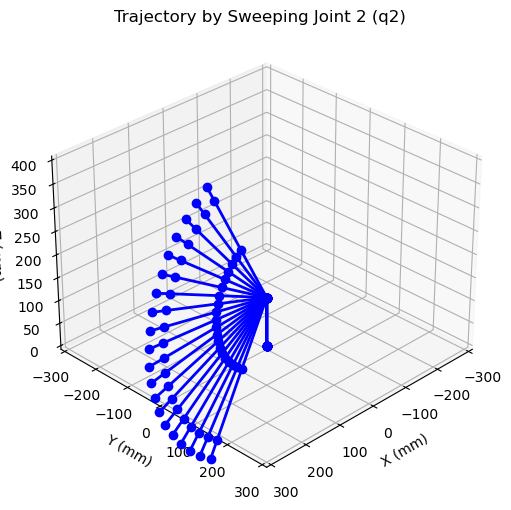

In [46]:
# Cell 11: Generate a trajectory by sweeping q2

q1, q3, q4 = 0, 0, 0  # keep other joints fixed
angles = np.linspace(-60, 60, 20)

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')

for q2 in angles:
    plot_dobot([q1, q2, q3, q4], ax=ax, show=False)

ax.set_title("Trajectory by Sweeping Joint 2 (q2)")
plt.show()

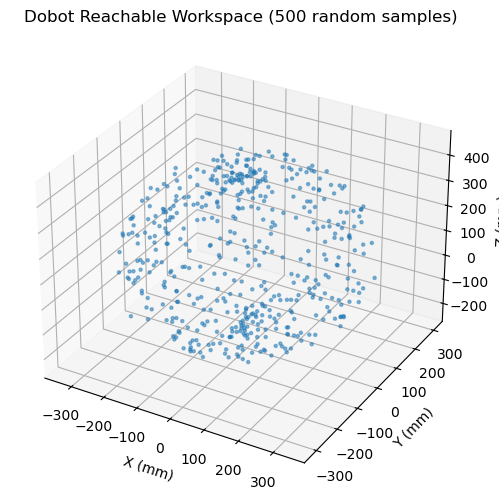

In [60]:
# Cell 12: Plot workspace sampling
num_samples = 500
points = []

for _ in range(num_samples):
    q1 = np.radians(np.random.uniform(-180, 180))
    q2 = np.radians(np.random.uniform(-90, 90))
    q3 = np.radians(np.random.uniform(-90, 90))
    q4 = np.radians(np.random.uniform(-90, 90))
    
    T, pose = forward_kinematics([q1, q2, q3, q4])  # unpack properly
    x, y, z, phi = pose                             # pose contains (x,y,z,phi)
    points.append([x,y,z])

points = np.array(points)

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points[:,0], points[:,1], points[:,2], s=5, alpha=0.5)
ax.set_title("Dobot Reachable Workspace (500 random samples)")
ax.set_xlabel("X (mm)")
ax.set_ylabel("Y (mm)")
ax.set_zlabel("Z (mm)")
plt.show()

Solution 1: [  0.         -75.12511061 111.03333868 -35.90822807] (degrees)
FK Position = (200.00, 0.00, 164.00), Error = 114.0000 mm

Solution 2: [   0.           35.90822807 -111.03333868   75.12511061] (degrees)
FK Position = (200.00, 0.00, 164.00), Error = 114.0000 mm



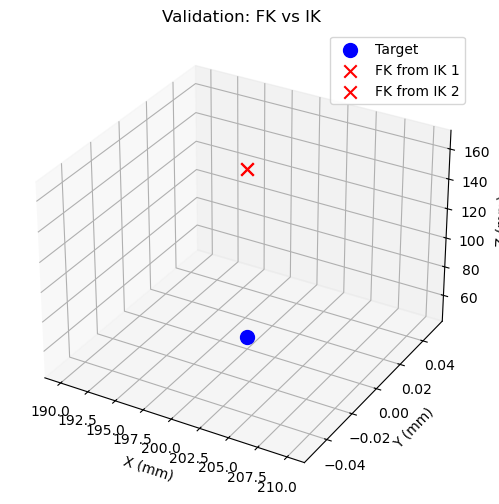

In [66]:
# Cell 13: Compare FK vs IK with error check
target_pose = [200, 0, 50, 0.0]   # x, y, z, phi (phi=0 rad for simplicity)
solutions = inverse_kinematics(*target_pose)

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')

# plot target point
ax.scatter(target_pose[0], target_pose[1], target_pose[2], 
           c='b', s=100, label="Target")

# plot FK result for each IK solution + error
for i, sol in enumerate(solutions):
    T, pose = forward_kinematics(sol)
    x, y, z, phi = pose
    
    # calculate error
    error = np.linalg.norm([x - target_pose[0],
                            y - target_pose[1],
                            z - target_pose[2]])
    
    print(f"Solution {i+1}: {np.degrees(sol)} (degrees)")
    print(f"FK Position = ({x:.2f}, {y:.2f}, {z:.2f}), Error = {error:.4f} mm\n")
    
    ax.scatter(x, y, z, c='r', marker='x', s=80, label=f"FK from IK {i+1}")

ax.legend()
ax.set_title("Validation: FK vs IK")
ax.set_xlabel("X (mm)")
ax.set_ylabel("Y (mm)")
ax.set_zlabel("Z (mm)")
plt.show()

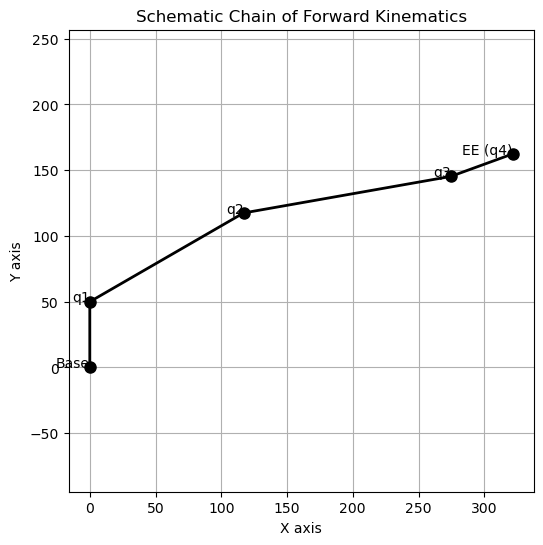

In [68]:
# Define simple link lengths (in mm)
L1 = 50   # base height
L2 = 135  # link 2
L3 = 160  # link 3
L4 = 50   # small end effector link

def schematic_fk(q1, q2, q3, q4):
    # Convert to radians
    q1, q2, q3, q4 = np.radians([q1, q2, q3, q4])

    # Base (fixed)
    x0, y0 = 0, 0

    # Joint 1 rotation only affects XY plane
    x1 = 0
    y1 = L1  # vertical base height shown in 2D (side view)

    # Joint 2
    x2 = x1 + L2 * np.cos(q2)
    y2 = y1 + L2 * np.sin(q2)

    # Joint 3
    x3 = x2 + L3 * np.cos(q2 + q3)
    y3 = y2 + L3 * np.sin(q2 + q3)

    # End effector (Joint 4 orientation)
    x4 = x3 + L4 * np.cos(q2 + q3 + q4)
    y4 = y3 + L4 * np.sin(q2 + q3 + q4)

    # Plot schematic
    plt.figure(figsize=(6,6))
    plt.plot([x0, x1, x2, x3, x4], [y0, y1, y2, y3, y4], 'k-o', linewidth=2, markersize=8)

    # Labels
    plt.text(x0, y0, "Base", fontsize=10, ha="right")
    plt.text(x1, y1, "q1", fontsize=10, ha="right")
    plt.text(x2, y2, "q2", fontsize=10, ha="right")
    plt.text(x3, y3, "q3", fontsize=10, ha="right")
    plt.text(x4, y4, "EE (q4)", fontsize=10, ha="right")

    plt.title("Schematic Chain of Forward Kinematics")
    plt.xlabel("X axis")
    plt.ylabel("Y axis")
    plt.grid(True)
    plt.axis("equal")
    plt.show()

# Example usage
schematic_fk(q1=0, q2=30, q3=-20, q4=10)